In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import inference, get_loglik, get_peak_pred, plot_params, simulate_lc, infer_lgfs
from matplotlib.offsetbox import AnchoredText

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-fixrho-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
# Y = Y[:, 2:]
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([100000, 5])
normalized X mean: -1.1743464469848672
X std: 1.046597228312195


In [3]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [4]:
size = 4096 * 4

In [5]:
X_gap = torch.tensor(np.load('/work/hmzhao/X_gap.npy'))

# CDE interpolation with log_sig
depth = 3; window_length = max(X_gap.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_gap, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

pis_gap, locs_gap, scales_gap = inference(model, size, 4096, coeffs, device, full_cov=False)

pred_gap = get_peak_pred(pis_gap, locs_gap, scales_gap, Y)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

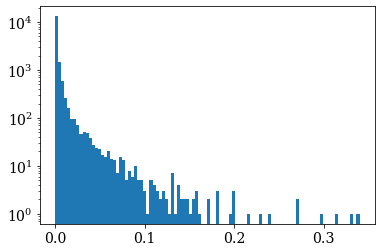

In [6]:
plt.hist((torch.mean(X[:size, :, 1], dim=1) - torch.mean(X_gap[:size, :, 1], dim=1)).numpy()**2, bins=100, log=True)
plt.show()

In [7]:
ind = (torch.mean(X[:, :, 1], dim=1) - torch.mean(X_gap[:, :, 1], dim=1)).numpy()**2 > 0.05
ind[size:] = False

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.24718131 -0.07421306  0.22684473  1.61797688 -0.09365742]
pred gap close:  [0.2842842638492584, -3, -0.06406406313180923, 0.2132132202386856, 1.5915915966033936, -0.14014014601707458]
pred gap global:  [0.2842842638492584, -3, -0.23623622953891754, 0.2132132202386856, 1.5915915966033936, -0.14014014601707458]
30


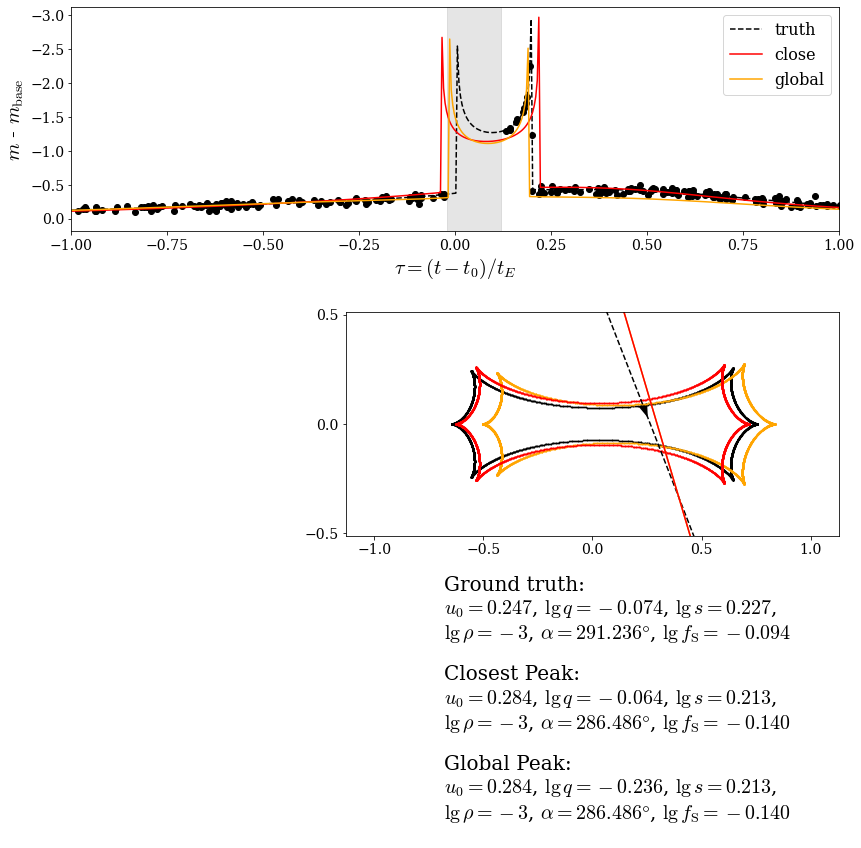

In [19]:
i = 30
fig = plt.figure(1, (12, 12))

ax_lc = plt.subplot2grid(shape=(3, 3), loc=(0, 0), rowspan=1, colspan=3)
plt.xlabel(r'$\tau=(t - t_0)/t_E$', fontsize=20)
plt.ylabel(r'$m$ - $m_{\rm base}$', fontsize=20)
# plt.gca().set_aspect(0.1)
plt.xlim(-1, 1)
# plt.ylim(-3, 1)
# plt.scatter(X[ind][i, :, 0], X[ind][i, :, 1]*0.2, color='grey', marker='o', s=20, rasterized=True)
gap_times = np.setdiff1d(np.floor(X[ind][i, :, 0]*1e3), np.floor(X_gap[ind][i, :, 0]*1e3))/1e3
plt.axvspan(gap_times.min(), gap_times.max(), color='grey', alpha=0.2)
plt.scatter(X_gap[ind][i, :, 0], X_gap[ind][i, :, 1]*0.2, color='black', marker='o', rasterized=True)
param_true = Y[ind][i].tolist()
param_true.insert(1, -3)
# param_pred = pred_close[ind[:size]][i].tolist()
# param_pred.insert(1, -3)
param_pred_gap = pred_gap[2][ind[:size]][i].tolist()
# param_pred_gap = km.cluster_centers_[1].tolist()
param_pred_gap.insert(1, -3)
param_pred_gap_g = pred_gap[0][ind[:size]][i].tolist()
# param_pred_gap_g = km.cluster_centers_[0].tolist()
param_pred_gap_g.insert(1, -3)
lc_true = simulate_lc(0, 1, *param_true, orig=True)
# lc_pred = simulate_lc(0, 1, *param_pred, orig=True)
lc_pred_gap = simulate_lc(0, 1, *param_pred_gap, orig=True)
lc_pred_gap_g = simulate_lc(0, 1, *param_pred_gap_g, orig=True)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
# plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='close')
plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='global')
param_gt_example = Y[ind][i].numpy()
param_predgap_example = pred_gap[2][ind[:size]][i].numpy()
print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
print('ground truth: ', Y[ind][i].numpy())
# print('pred no gap: ', pred_global[ind[:size]][i].numpy())
print('pred gap close: ', param_pred_gap)
print('pred gap global: ', param_pred_gap_g)
print(i)
plt.gca().invert_yaxis()
plt.legend(prop={'size': 16})

# plt.axes([0.7, 0.4, 0.2, 0.4])


param_list = [param_true, param_pred_gap_g, param_pred_gap]
# param_list = [Y[ind][i].tolist(), None, pred_gap[2][ind[:size]][i].tolist()]
traj_color = ['black', 'orange', 'red']
cau_color = ['black', 'orange', 'red']

ax_geo = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1, colspan=2)
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-0.3, 0.3)
plt.yticks([-0.5, 0, 0.5])
for j, params in enumerate(param_list):
    if j != 10:
        u_0, lgrho, lgq, lgs, alpha_180, lgfs = params
        parameters = {
                    't_0': 0,
                    't_E': 1,
                    'u_0': u_0,
                    'rho': 10**lgrho, 
                    'q': 10**lgq, 
                    's': 10**lgs, 
                    'alpha': alpha_180*180,
                }
        modelmm = mm.Model(parameters, coords=None)
        if j == 0:
            modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=True, color=traj_color[j], linestyle='dashed')
        else:
            modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[j])
        modelmm.plot_caustics(color=cau_color[j], s=3)

ax = plt.subplot2grid((3, 3), (2, 1), rowspan=1, colspan=2)
ax.axis('off')
plt.text(0.2, 0.9, r'Ground truth:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
    param_true[0], param_true[2], param_true[3], param_true[1], param_true[4]*180, param_true[5]
), fontsize=20)
plt.text(0.2, 0.5, r'Closest Peak:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
    param_pred_gap[0], param_pred_gap[2], param_pred_gap[3], param_pred_gap[1], param_pred_gap[4]*180, param_pred_gap[5]
), fontsize=20)
plt.text(0.2, 0.1, r'Global Peak:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
    param_pred_gap_g[0], param_pred_gap_g[2], param_pred_gap_g[3], param_pred_gap_g[1], param_pred_gap_g[4]*180, param_pred_gap_g[5]
), fontsize=20)

plt.tight_layout()
plt.savefig('./lc_gap.pdf')

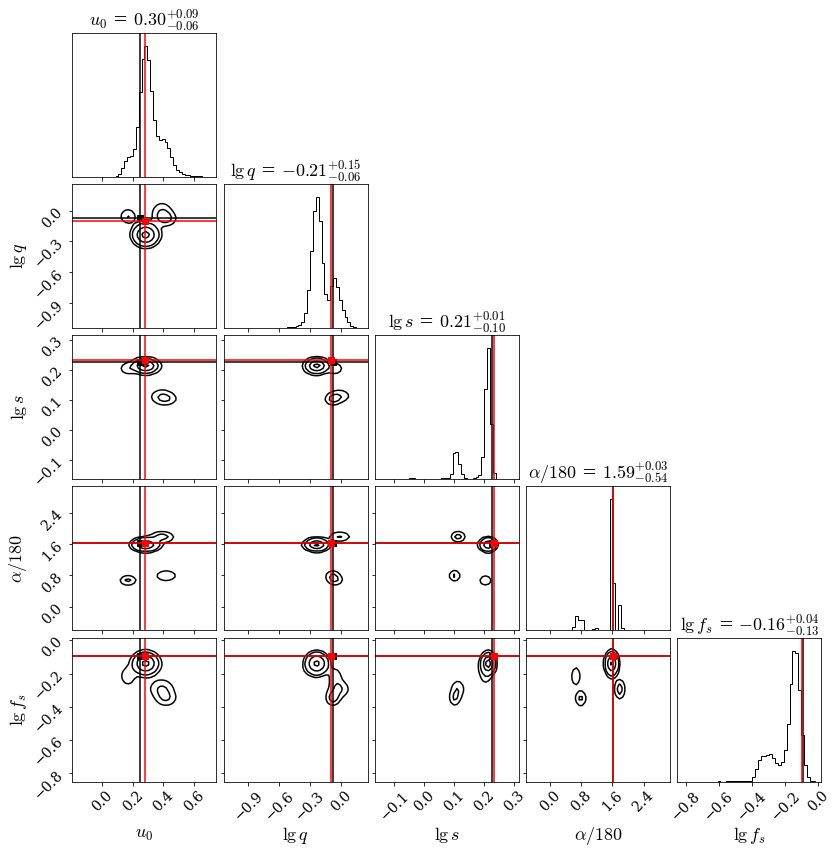

In [20]:
n = int(1e6)

pi = pis_gap[ind[:size]][i]; loc = locs_gap[ind[:size]][i]; scale = scales_gap[ind[:size]][i]
# pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1, 1))
pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
# normal = torch.distributions.MultivariateNormal(loc, scale)
normal = torch.distributions.Normal(loc, scale)
pi_dist = torch.distributions.OneHotCategorical(probs=pi)
sample_gap = model.sample(pi_dist, normal).numpy()

truths = Y[ind][i].numpy()
# truths = np.delete(truths, 1)
# print(truths)

# range_p = [(0.8, 1.2), (-1.6, -1), (0.35, 0.45), (1.1, 1.2), (-0.2, 0.2)] # 53
# range_p = [(0, 0.15), (-2, 0), (-0.4, 0.4), (0, 2), (-0.5, 0)] # 77
range_p = None
corner.corner(sample_gap, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            label_kwargs={"fontsize": 18},
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 18},
            truths=truths, truth_color='black', 
            fill_contours=False, color='black',  no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            )
# corner.overplot_lines(plt.gcf(), pred_gap[2][ind[:size]][i].tolist(), color="red")
# corner.overplot_points(plt.gcf(), pred_gap[2][ind[:size]][i][None], marker="s", color="red")
# corner.overplot_lines(plt.gcf(), pred_gap[0][ind[:size]][i].tolist(), color="orange")
# corner.overplot_points(plt.gcf(), pred_gap[0][ind[:size]][i][None], marker="s", color="orange")
corner.overplot_lines(plt.gcf(), np.array(param_best)[[0, 2, 3, 4, 5]], color="red")
corner.overplot_points(plt.gcf(), np.array(param_best)[[0, 2, 3, 4, 5]][None], marker="s", color="red")

plt.savefig('./corner_gap.pdf')
plt.show()

In [8]:
from scipy.optimize import fmin
import VBBinaryLensing

def get_fsfb(amp, flux, ferr):
    sig2 = ferr**2
    wght = flux/sig2
    d = np.ones(2)
    d[0] = np.sum(wght*amp)
    d[1] = np.sum(wght)
    b = np.zeros((2,2))
    b[0,0] = np.sum(amp**2/sig2)
    b[0,1] = np.sum(amp/sig2)
    b[1,0] = b[0,1]
    b[1,1] = np.sum(1./sig2)
    c = np.linalg.inv(b)
    fs = np.sum(c[0]*d)
    fb = np.sum(c[1]*d)
    fserr = np.sqrt(c[0,0])
    fberr = np.sqrt(c[1,1])
    fmod = fs*amp+fb
    chi2 = np.sum((flux-fmod)**2/sig2)
    return chi2,fs,fb,fserr,fberr

def compute_model_lc(time_array, fitting_parameters, VBBL):
    u0, lgq, lgs, ad180 = fitting_parameters
    q, s = 10**lgq, 10**lgs
    alpha = ad180 * np.pi # convert to radian
    t0, te, rho = 0, 1, 1e-3
    tau = (time_array-t0)/te
    xs = tau*np.cos(alpha) - u0*np.sin(alpha)
    ys = tau*np.sin(alpha) + u0*np.cos(alpha)
    magnifications = np.array([VBBL.BinaryMag2(s, q, xs[i], ys[i], rho) for i in range(len(xs))])
    return magnifications

def compute_chisq(fitting_parameters, time, flux, ferr, VBBL, return_model=False, penalty=False):
        magnifications = compute_model_lc(time, fitting_parameters, VBBL)
        chi2, fs, fb, fserr, fberr = get_fsfb(magnifications, flux, ferr)
        if return_model:
            return chi2, fs, fb
        return chi2

def perform_optimization(time, flux, ferr, para_initial, verbose=True):
    VBBL = VBBinaryLensing.VBBinaryLensing()

    para_best, chi2_min, iter, funcalls, warnflag, allevcs = fmin(compute_chisq, para_initial, args=(time, flux, ferr, VBBL), full_output=True, retall=True, maxiter=1000, maxfun=5000, disp=verbose)

    chi2_min, fs, fb = compute_chisq(para_initial, time, flux, ferr, VBBL, return_model=True)
    if verbose:
        print('initial chisq: ', chi2_min)
    chi2_min, fs, fb = compute_chisq(para_best, time, flux, ferr, VBBL, return_model=True)
    if verbose:
        print('best chisq & (fs, fb): ', chi2_min, fs, fb)
    time_model = np.arange(-2, 2, 0.001)
#    magnifications = compute_model_lc(time_model, para_initial, VBBL)
    magnifications = compute_model_lc(time_model, para_best, VBBL)
    mag_model = 18 - 2.5*np.log10(magnifications*fs + fb)
    model = np.vstack((time_model, mag_model))
    return para_best, chi2_min, model, warnflag

def prepare_lc_mdn(X, pis, locs):
    mag = X[:, :, 1] / 5 + 18
    flux = 10 ** (0.4 * (18 - mag))
    merr = torch.ones_like(mag) * 0.033
    ferr = merr*flux*np.log(10)/2.5
    # times, mag, flux, ferr
    lc = torch.stack([X[:, :, 0], mag, flux, ferr], dim=-1)
    first_indices = torch.arange(len(pis))[:, None]
    order = torch.argsort(pis, dim=-1, descending=True)
    pis = pis[first_indices, order]
    locs = locs[first_indices, order]
    return lc.numpy(), pis.numpy(), locs.numpy()

In [9]:
lc, pis_sort, locs_sort = prepare_lc_mdn(X_gap[ind], pis_gap[ind[:size]], locs_gap[ind[:size]])

  0%|          | 0/1 [00:00<?, ?it/s]

[ 0.2838339  -0.23552181  0.21430476  1.5914048 ]
Optimization terminated successfully.
         Current function value: 476.880581
         Iterations: 639
         Function evaluations: 1076
initial chisq:  5027.42878460157
best chisq & (fs, fb):  476.8805811069607 0.8033096450393096 0.20000945692547845
parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.24718131 -0.07421306  0.22684473  1.61797688 -0.09365742]
pred gap close:  [0.2842842638492584, -3, -0.06406406313180923, 0.2132132202386856, 1.5915915966033936, -0.14014014601707458]
pred gap global:  [0.2842842638492584, -3, -0.23623622953891754, 0.2132132202386856, 1.5915915966033936, -0.14014014601707458]
30
[ 4.76880581e+02  0.00000000e+00  2.80294105e-01 -9.92645899e-02
  2.34505726e-01  1.61666843e+00 -9.65560994e-02]
[0.2471813067302584, -3, -0.07421305578875347, 0.22684472843864786, 1.6179768775730448, -0.09365741993733755]
[0.28029410468008237, -3, -0.0992645898689881, 0.23450572586451898, 1.616668426339152, -0.

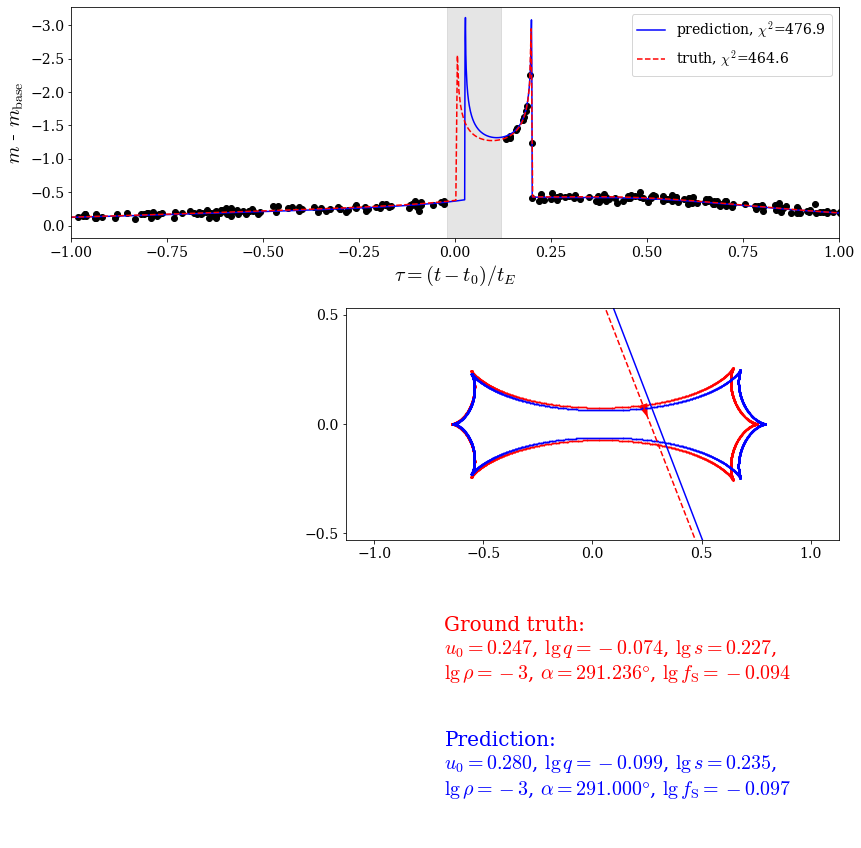

In [10]:
i = 30
fig = plt.figure(1, (12, 12))

ax_lc = plt.subplot2grid(shape=(3, 3), loc=(0, 0), rowspan=1, colspan=3)

verbose = True

best_parameters = []
for index in tqdm(range(1)):
    para_initial = locs_sort[i, index, :-1]
    if verbose:
        print(para_initial)
    para_best, chi2_min, model, warnflag = perform_optimization(lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], para_initial, verbose=verbose)
    chi2_min, fs, fb = compute_chisq(para_best, lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)
    best_parameters.append(np.hstack((chi2_min, warnflag, para_best)))
    best_parameters = np.concatenate((best_parameters[0], np.array([np.log10(fs/(fs+fb))])))
    plt.plot(model[0], model[1]-18, label=r'prediction, $\chi^2$=%.1f'%(chi2_min), color='blue')

chi2_min, fs, fb = compute_chisq(Y[ind][i, :-1].numpy(), lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)

plt.xlabel(r'$\tau=(t - t_0)/t_E$', fontsize=20)
plt.ylabel(r'$m$ - $m_{\rm base}$', fontsize=20)
# plt.gca().set_aspect(0.1)
plt.xlim(-1, 1)
# plt.ylim(-3, 1)
# plt.scatter(X[ind][i, :, 0], X[ind][i, :, 1]*0.2, color='grey', marker='o', s=20, rasterized=True)
gap_times = np.setdiff1d(np.floor(X[ind][i, :, 0]*1e3), np.floor(X_gap[ind][i, :, 0]*1e3))/1e3
plt.axvspan(gap_times.min(), gap_times.max(), color='grey', alpha=0.2)
plt.scatter(X_gap[ind][i, :, 0], X_gap[ind][i, :, 1]*0.2, color='black', marker='o', rasterized=True)
param_true = Y[ind][i].tolist()
param_true.insert(1, -3)
# param_pred = pred_close[ind[:size]][i].tolist()
# param_pred.insert(1, -3)
param_pred_gap = pred_gap[2][ind[:size]][i].tolist()
# param_pred_gap = km.cluster_centers_[1].tolist()
param_pred_gap.insert(1, -3)
param_pred_gap_g = pred_gap[0][ind[:size]][i].tolist()
# param_pred_gap_g = km.cluster_centers_[0].tolist()
param_pred_gap_g.insert(1, -3)
lc_true = simulate_lc(0, 1, *param_true, orig=True)
# lc_pred = simulate_lc(0, 1, *param_pred, orig=True)
lc_pred_gap = simulate_lc(0, 1, *param_pred_gap, orig=True)
lc_pred_gap_g = simulate_lc(0, 1, *param_pred_gap_g, orig=True)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='red', linestyle='dashed', label='truth, $\chi^2$=%.1f' % chi2_min)
# plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
# chi2_min, fs, fb = compute_chisq(pred_gap[2][ind[:size]][i].tolist()[:-1], lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)
# plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='close, $\chi^2$=%.1f' % chi2_min)
# chi2_min, fs, fb = compute_chisq(pred_gap[0][ind[:size]][i].tolist()[:-1], lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)
# plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='global, $\chi^2$=%.1f' % chi2_min)
param_gt_example = Y[ind][i].numpy()
param_predgap_example = pred_gap[2][ind[:size]][i].numpy()
print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
print('ground truth: ', Y[ind][i].numpy())
# print('pred no gap: ', pred_global[ind[:size]][i].numpy())
print('pred gap close: ', param_pred_gap)
print('pred gap global: ', param_pred_gap_g)
print(i)
plt.gca().invert_yaxis()
plt.legend(prop={'size': 14})

# plt.axes([0.7, 0.4, 0.2, 0.4])

print(best_parameters)
param_best = list(best_parameters[2:])
param_best.insert(1, -3)
# param_list = [param_true, param_pred_gap_g, param_pred_gap]
param_list = [param_true, None, param_best]
# param_list = [Y[ind][i].tolist(), None, pred_gap[2][ind[:size]][i].tolist()]
traj_color = ['red', 'orange', 'blue']
cau_color = ['red', 'orange', 'blue']

ax_geo = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1, colspan=2)
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-0.3, 0.3)
plt.yticks([-0.5, 0, 0.5])
for j, params in enumerate(param_list):
    if j != 1:
        print(params)
        u_0, lgrho, lgq, lgs, alpha_180, lgfs = params
        parameters = {
                    't_0': 0,
                    't_E': 1,
                    'u_0': u_0,
                    'rho': 10**lgrho, 
                    'q': 10**lgq, 
                    's': 10**lgs, 
                    'alpha': alpha_180*180,
                }
        modelmm = mm.Model(parameters, coords=None)
        if j == 0:
            modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=True, color=traj_color[j], linestyle='dashed')
        else:
            modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[j])
        modelmm.plot_caustics(color=cau_color[j], s=3)

ax = plt.subplot2grid((3, 3), (2, 1), rowspan=1, colspan=2)
ax.axis('off')
plt.text(0.2, 0.7, r'Ground truth:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
    param_true[0], param_true[2], param_true[3], param_true[1], param_true[4]*180, param_true[5]
), fontsize=20, color='red')
# plt.text(0.2, 0.5, r'Closest Peak:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
#     param_pred_gap[0], param_pred_gap[2], param_pred_gap[3], param_pred_gap[1], param_pred_gap[4]*180, param_pred_gap[5]
# ), fontsize=20)
# plt.text(0.2, 0.1, r'Global Peak:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
#     param_pred_gap_g[0], param_pred_gap_g[2], param_pred_gap_g[3], param_pred_gap_g[1], param_pred_gap_g[4]*180, param_pred_gap_g[5]
# ), fontsize=20)
plt.text(0.2, 0.2, r'Prediction:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
    param_best[0], param_best[2], param_best[3], param_best[1], param_best[4]*180, param_best[5]
), fontsize=20, color='blue')

plt.tight_layout()
plt.savefig('./lc_gap.pdf')

In [24]:
np.savez('./gm_30.npz', pi=pi[0], loc=loc[0].numpy(), scale=scale[0].numpy())

In [26]:
pi = np.load('./gm_30.npz')['pi']
loc = np.load('./gm_30.npz')['loc']
scale = np.load('./gm_30.npz')['scale']

array([1.5740655e-06, 1.4989619e-02, 6.3457754e-03, 1.7344827e-03,
       6.8386990e-01, 4.2721229e-03, 6.9480292e-02, 2.2817526e-02,
       1.0999587e-01, 8.1492580e-02, 3.8396064e-03, 1.1606993e-03],
      dtype=float32)

In [8]:
def ecdf(x):
    xnew = np.sort(x)
    xval, cdf = [], []
    for i in range(len(xnew)):
        cdf.append(i)
        xval.append(xnew[i])
        cdf.append(i+1)
        xval.append(xnew[i])
    cdf = np.array(cdf)/cdf[-1]
    xval = np.array(xval)
    return xval, cdf

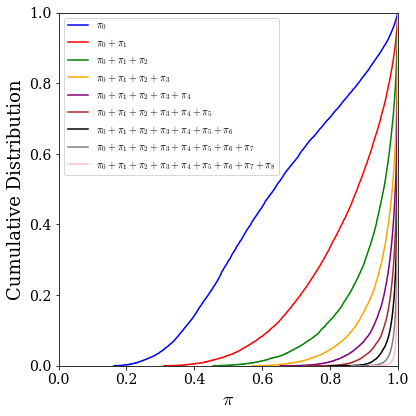

In [15]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
# plt.hist(pis_gap.sort(dim=-1)[0][:, -1:].sum(dim=-1).numpy(), bins=100, density=True, cumulative=True, histtype='step', color='blue')
# plt.hist(pis_gap.sort(dim=-1)[0][:, -2:].sum(dim=-1).numpy(), bins=100, density=True, cumulative=True, histtype='step', color='red')
# plt.hist(pis_gap.sort(dim=-1)[0][:, -3:].sum(dim=-1).numpy(), bins=100, density=True, cumulative=True, histtype='step', color='green')
plt.plot(*ecdf(pis_gap.sort(dim=-1)[0][:, -1:].sum(dim=-1).numpy()), label=r'$\pi_0$', color='blue')
plt.plot(*ecdf(pis_gap.sort(dim=-1)[0][:, -2:].sum(dim=-1).numpy()), label=r'$\pi_0+\pi_1$', color='red')
plt.plot(*ecdf(pis_gap.sort(dim=-1)[0][:, -3:].sum(dim=-1).numpy()), label=r'$\pi_0+\pi_1+\pi_2$', color='green')
plt.plot(*ecdf(pis_gap.sort(dim=-1)[0][:, -4:].sum(dim=-1).numpy()), label=r'$\pi_0+\pi_1+\pi_2+\pi_3$', color='orange')
plt.plot(*ecdf(pis_gap.sort(dim=-1)[0][:, -5:].sum(dim=-1).numpy()), label=r'$\pi_0+\pi_1+\pi_2+\pi_3+\pi_4$', color='purple')
plt.plot(*ecdf(pis_gap.sort(dim=-1)[0][:, -6:].sum(dim=-1).numpy()), label=r'$\pi_0+\pi_1+\pi_2+\pi_3+\pi_4+\pi_5$', color='brown')
plt.plot(*ecdf(pis_gap.sort(dim=-1)[0][:, -7:].sum(dim=-1).numpy()), label=r'$\pi_0+\pi_1+\pi_2+\pi_3+\pi_4+\pi_5+\pi_6$', color='black')
plt.plot(*ecdf(pis_gap.sort(dim=-1)[0][:, -8:].sum(dim=-1).numpy()), label=r'$\pi_0+\pi_1+\pi_2+\pi_3+\pi_4+\pi_5+\pi_6+\pi_7$', color='gray')
plt.plot(*ecdf(pis_gap.sort(dim=-1)[0][:, -9:].sum(dim=-1).numpy()), label=r'$\pi_0+\pi_1+\pi_2+\pi_3+\pi_4+\pi_5+\pi_6+\pi_7+\pi_8$', color='pink')
plt.xlabel(r'$\pi$', fontsize=18)
plt.ylabel(r'Cumulative Distribution', fontsize=18)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(fontsize=10, loc='upper left')

plt.tight_layout()
plt.savefig('./cdf_pi.pdf')
plt.show()

In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
scores = []
for k in tqdm(range(2, 10)):
    km = KMeans(n_clusters=k, random_state=0, max_iter=1000, tol=1e-6).fit(sample_gap)
    scores.append(silhouette_score(sample_gap, km.labels_, sample_size=1000))

  0%|          | 0/8 [00:00<?, ?it/s]

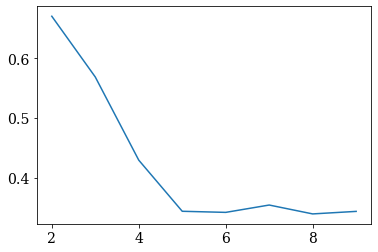

In [75]:
plt.plot(range(2, 10), scores)

In [82]:
km = KMeans(n_clusters=3, random_state=0, max_iter=1000, tol=1e-6).fit(sample_gap)
km.cluster_centers_

array([[ 0.1209591 , -0.88009995, -0.3066806 ,  1.6182134 , -0.18090063],
       [ 0.13395631, -0.6081328 , -0.35454443,  0.96912694, -0.1651477 ],
       [ 0.13031827, -1.46749   ,  0.05400106,  0.5880692 , -0.17834716]],
      dtype=float32)

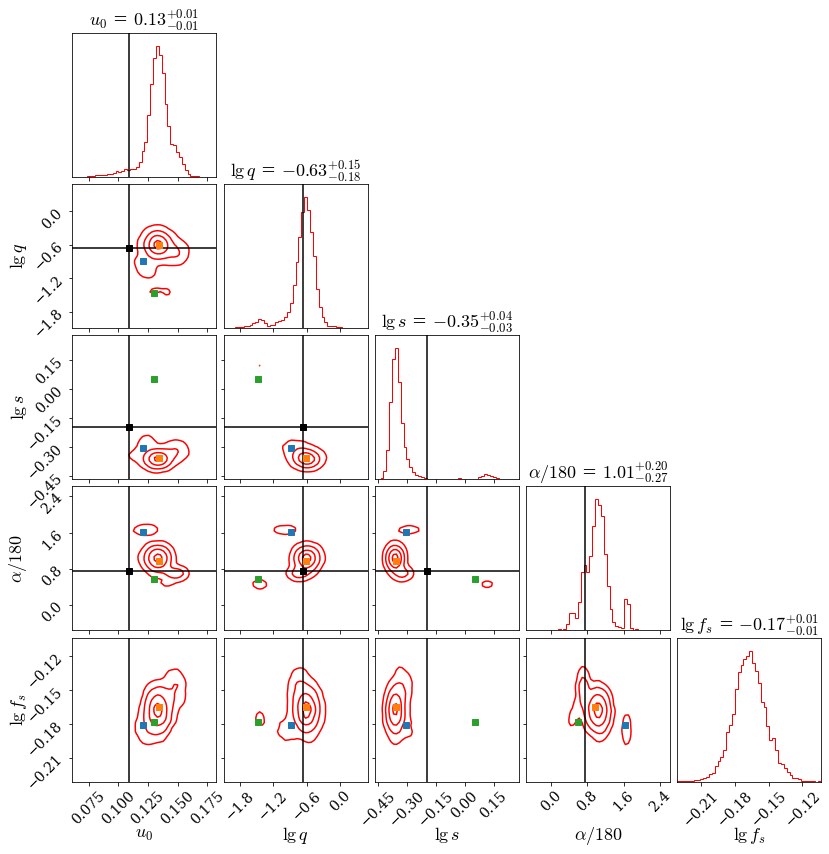

In [83]:
corner.corner(sample_gap, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            label_kwargs={"fontsize": 18},
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 18},
            truths=truths, truth_color='black', 
            fill_contours=False, color='red',  no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            )
for i in range(len(km.cluster_centers_)):
    corner.overplot_points(plt.gcf(), km.cluster_centers_[i][None], marker="s")
    # corner.overplot_lines(plt.gcf(), km.cluster_centers_[i])
plt.show()

[0.6838699  0.10999587 0.08149258 0.06948029]
[0.2471813067302584, -0.07421305578875347, 0.22684472843864786, 1.6179768775730448, -0.09365741993733755]


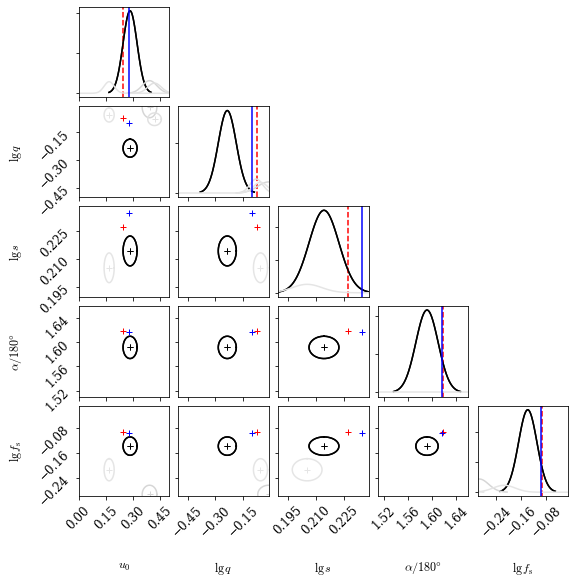

In [11]:
plt.rc('font', size=12)
import plot_triangle
## first sort the gaussians according to the weight ##
i = 30
pi = pis_gap[ind[:size]][i].numpy()
mu = locs_gap[ind[:size]][i].numpy()
scale = scales_gap[ind[:size]][i].numpy()
order = np.argsort(pi)[::-1]
pi = pi[order][:4]
mu = mu[order][:4]
scale = scale[order][:4]
print(pi)
## the ground truth ##
# param_true = [0.34033019, -0.35541759, 0.01886, 1.18859352, -0.8133]
param_true = Y[ind][i].tolist()
print(param_true)
#param_true = [0.247, -0.074, 0.227, 291.236/180, -0.094]
param_pred = np.zeros_like(param_true)
norm_fac = np.zeros_like(param_true)

n_param = len(mu[0])
labels = [r'$u_0$', r'$\lg q$', r'$\lg s$', r'$\alpha/180\degree$', r'$\lg f_{\rm s}$']

param_ranges = [[0, 0.5], [-0.5, -0.01], [0.19, 0.238], [1.51, 1.66], [-0.3, -0.01]]
for j_gauss in range(len(pi)):
    weight = pi[j_gauss]/pi[0] # normalize the weight by the highest value, so that the color appears better
    cov_mat = np.zeros((n_param, n_param))
    for i in range(len(mu[j_gauss])):
        cov_mat[i, i] = scale[j_gauss, i]**2
    norm_fac += pi[j_gauss] #/np.linalg.det(cov_mat)
    param_pred += mu[j_gauss] * pi[j_gauss] #/np.linalg.det(cov_mat) * mu[j_gauss]
    if j_gauss == 0:
        fig, axes = plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, weight=weight, ground_truth=param_true, ground_truth_ls='dashed')
    if j_gauss == len(pi)-1:
        param_pred /= norm_fac
        # plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, fig=fig, axes=axes, weight=weight)
        plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, fig=fig, axes=axes, weight=weight, extents=param_ranges, ground_truth=np.array(param_best)[[0, 2, 3, 4, 5]], ground_truth_color='blue', ground_truth_ls='-')
    else:
        plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, fig=fig, axes=axes, weight=weight)

plt.savefig('./corner_gap.pdf')

# corner.overplot_lines(plt.gcf(), np.array(param_best)[[0, 2, 3, 4, 5]], color="red")
# corner.overplot_points(plt.gcf(), np.array(param_best)[[0, 2, 3, 4, 5]][None], marker="+", color="blue")